# Modelo de previsão de valor de imóveis no Brasil
- O modelo tem como objetivo prever não só o valor do imóvel mas o IPTU e o valor de condóminio do imóvel perante um formulario a ser enviado pelo usuário.
- No momento possuo somente o modelo de predição de valor do imóvel

In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
import requests
import os
import logging
import joblib

from dotenv import load_dotenv
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from learning_curve import plot_learning_curve

### Configurações básicas de logger e carregamento de variáveis de ambiente

In [2]:
# Configurando o logging
logging.basicConfig(
    level=logging.INFO, # Nível mínimo para exibir
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
)

# Crie uma instância do logger para este módulo
logger = logging.getLogger(__name__)

load_dotenv()

sns.set_theme(style="whitegrid")

### Requisição dos dados por meio de uma API

In [3]:
API_URL = "http://127.0.0.1:8000/consult-all-datas"
SECRET_KEY = os.getenv("API_KEY")

headers = {
    "X-API-KEY":SECRET_KEY
}

try:
    response = requests.get(url=API_URL, headers=headers)
    
    response.raise_for_status()
    
    data = response.json()
    
    if data:
        df = pd.DataFrame(data)
        logger.info("Dados carregados no DataFrame com sucesso!")
        logger.info(f"Total de registros: {len(df)}")
        logger.info(f" ---> Primeiras 5 linhas: \n \n{df.head()}")
        logger.info("\nInformações do DataFrame:")
        df.info()
    else:
        logger.info("A API retornou uma lista vazia.")
except requests.exceptions.HTTPError as http_error:
    logger.error(f"Erro HTTP ocorreu: {http_error}")
    logger.error(f"Conteúdo da resposta: {response.text}")
except requests.exceptions.RequestException as req_error:
    logger.error(f"Erro da requisição ocorreu: {req_error}")

2025-10-01 17:49:56 - __main__ - INFO - Dados carregados no DataFrame com sucesso!
2025-10-01 17:49:56 - __main__ - INFO - Total de registros: 33940
2025-10-01 17:49:56 - __main__ - INFO -  ---> Primeiras 5 linhas: 
 
           id property_type      price  price_condominium   iptu  area_m2  \
0  2838574939          casa  2450000.0                NaN    NaN      198   
1  2838818725          casa   480000.0                NaN  144.0      110   
2  2833329978     quitinete   675000.0              750.0  120.0       35   
3  2827498230   apartamento   185000.0              250.0    NaN       50   
4  2795928117   apartamento   680000.0                NaN    NaN       94   

   rooms  bathrooms  vacancies                   city     neighborhood  
0      3          3          3                Pelotas           Centro  
1      3          3          4  Campos dos Goytacazes  Parque Imperial  
2      1          1          1         Rio de Janeiro       Copacabana  
3      2          1        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33940 entries, 0 to 33939
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 33940 non-null  object 
 1   property_type      33940 non-null  object 
 2   price              33940 non-null  float64
 3   price_condominium  16273 non-null  float64
 4   iptu               22784 non-null  float64
 5   area_m2            33940 non-null  int64  
 6   rooms              33940 non-null  int64  
 7   bathrooms          33940 non-null  int64  
 8   vacancies          33940 non-null  int64  
 9   city               33940 non-null  object 
 10  neighborhood       33940 non-null  object 
dtypes: float64(3), int64(4), object(4)
memory usage: 2.8+ MB


## Tratamento e limpeza dos dados

- Retiramos a coluna de id do dataset

In [4]:
tirar_colunas = df.drop("id", axis=1)
df = tirar_colunas

- Retiramos valores que não iremos utilizar no modelo

In [5]:
tirar_tipo_de_propriedade = df[df["property_type"] != "fazenda"]
tirar_tipo_de_propriedade = tirar_tipo_de_propriedade[tirar_tipo_de_propriedade["property_type"] != "terreno"]
tirar_tipo_de_propriedade = tirar_tipo_de_propriedade[tirar_tipo_de_propriedade["property_type"] != "studio"]
tirar_tipo_de_propriedade = tirar_tipo_de_propriedade[tirar_tipo_de_propriedade["property_type"] != "cobertura"]
tirar_tipo_de_propriedade = tirar_tipo_de_propriedade[tirar_tipo_de_propriedade["property_type"] != "flat"]
tirar_tipo_de_propriedade = tirar_tipo_de_propriedade[tirar_tipo_de_propriedade["property_type"] != "loft"]
df = tirar_tipo_de_propriedade

- Alterando para NaN os valores de algumas outliers de preço de condôminio, IPTU e imoveis com erros de digitação, dados de valores idénticos ou maiores que o preço do imovel.
- Caso esteja testando a aplicação, não precisa dessa linha de baixo, pode deletar do seu modelo.

In [6]:
df_limpo = df.copy()

# Altere os valores de condomínio na cópia
# Condição para valores menores ou iguais a R$ 69
condicao_cond = df_limpo["price_condominium"] <= 69
df_limpo.loc[condicao_cond, "price_condominium"] = np.nan

# Altere os valores de IPTU na mesma cópia
# Condição para valores menores ou iguais a R$ 89
condicao_iptu = df_limpo["iptu"] <= 89
df_limpo.loc[condicao_iptu, "iptu"] = np.nan

# Pegamos todos os valores que são iguais ou maiores que o preço do imovel e transformamos em NaN
condicao_cond_clean = df_limpo['price_condominium'] >= df_limpo['price']
condicao_iptu_clean = df_limpo['iptu'] >= df_limpo['price']

# Transformamos os valores para NaN
df_limpo.loc[condicao_cond_clean, 'price_condominium'] = np.nan
df_limpo.loc[condicao_iptu_clean, 'iptu'] = np.nan

# Indices que possuem valores extraordinarios de IPTU ou condôminio, e valores idênticos entre IPTU, condôminio e valor do imovel
indices_condo_alterar = [15923, 552, 16283, 9700, 15538, 14349, 551, 14735, 9530, 21054, 13929, 19067, 7579, 15181, 549, 15572, 9715, 21726, 26228, 26583, 33930, 27972, 25881, 30199, 22360, 13649] 
indices_iptu_alterar = [7610, 7087, 4002, 9117, 13921, 17834, 13168, 8992, 3983, 7055, 16285, 20099, 30701, 30015, 13467, 9157, 3993, 7101, 17116, 20812, 24910, 25923, 23280, 19652, 24616]

# Transformamos os valores para NaN
df_limpo.loc[indices_condo_alterar, 'price_condominium'] = np.nan
df_limpo.loc[indices_iptu_alterar, 'iptu'] = np.nan

# Pegamos os valores de vagas de garagem acima de 15 e transformamos para NaN, pois na base de dados possui valores como 1028 vagas de garagem
condicao_vacancies_exageradas = df_limpo['vacancies'] > 15
df_limpo.loc[condicao_vacancies_exageradas, 'vacancies'] = np.nan

df = df_limpo

### Imputando os dados faltantes
- Utilizei o algoritmo KNN como imputador, e coloquei 30 K-means para representar uma página de coleta de dados, pois cada página possuia 30 anúncios de imóveis.

In [7]:
imput_mean = KNNImputer(n_neighbors=30)
colunas_a_imputar = ["price", "price_condominium", "iptu", "area_m2", "rooms", "bathrooms", "vacancies"]
df_imputado = df[colunas_a_imputar].copy()
df_imputado = imput_mean.fit_transform(df_imputado)
df_imputado_colums = pd.DataFrame(df_imputado, columns=colunas_a_imputar)


- Atualizando o dataframe com os novos dados imputados

In [8]:
df_imputado_colums.index = df.index

df_atualizado = df.copy()
df_atualizado[colunas_a_imputar] = df_imputado_colums

## Pré-processamento dos dados e engenharia de features paro os modelos

- Separação dos dados de teste e treino mais a divisão de colunas númericas e categóricas.
- Vou retirar as features de bairro (neighborhood) e cidade (city) pois elas geram uma grande cardinalidade ao modelo e pode resultar em um modelo que não desempenha bem e será necessario uma base de dados maior ocasioanando um treinamento mais rigoroso e demorado.
- Atualmente a base de dados de agora, é 30000 ou mais dados de imoveis por tipo de imovel.
---
- Adicionei mais 3 novas colunas para facilitar o aprendizado do modelo, "rooms_totality" mostra a totalidade de comodos no imovel, "area_per_room" área total por comodo e "bathrooms_per_rooms" a quantidade de banheiros perante a quantidade de comodos.
- Casas com muitos banheiros são tratadas como imoveis de alto padrão do mesmo jeito que comodos muito grande.

In [9]:
df_atualizado["rooms_totality"] = df_atualizado["rooms"] + df_atualizado["bathrooms"]
df_atualizado["area_per_room"] = df_atualizado["area_m2"] / df_atualizado["rooms"].replace(0, 1)
df_atualizado["bathrooms_per_rooms"] = df_atualizado["bathrooms"] / df_atualizado["rooms"].replace(0, 1)
df_atualizado["iptu_log"] = np.log1p(df_atualizado["iptu"])

In [10]:
y_price = df_atualizado["price"]
y_price_condo = df_atualizado["price_condominium"]
y_iptu = df_atualizado["iptu_log"]
X = df_atualizado[["property_type", "area_m2", "rooms", "bathrooms", "vacancies", "rooms_totality", "area_per_room", "bathrooms_per_rooms"]]

num_features = ["area_m2", "rooms", "bathrooms", "vacancies", "rooms_totality", "area_per_room", "bathrooms_per_rooms"]
cat_features = ["property_type"]


In [11]:
X_train, X_test, y_train_price, y_test_price = train_test_split(X, y_price, test_size=0.2, random_state=42)
X_train, X_test, y_train_price_condo, y_test_price_condo = train_test_split(X, y_price_condo, test_size=0.2, random_state=42)
X_train, X_test, y_train_iptu, y_test_iptu = train_test_split(X, y_iptu, test_size=0.2, random_state=42)

### Criação da pipeline de pré-processamento

In [12]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
    # handle_unknown="ignore" é CRUCIAL. Evita um erro caso o teste tenha uma categória que não tinha no treino
])

pre_processor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)

In [13]:
pre_processor.fit(X_train)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [14]:
X_train_processed = pre_processor.transform(X_train)
X_test_processed = pre_processor.transform(X_test)

In [15]:
print("Shape dos dados de treino antes do pré-processamento:", X_train.shape)
print("Shape dos dados de treino após o pré-processamento:", X_train_processed.shape)
print("\nExemplo de uma linha transformada:")
print(X_train_processed[0])

Shape dos dados de treino antes do pré-processamento: (25678, 8)
Shape dos dados de treino após o pré-processamento: (25678, 11)

Exemplo de uma linha transformada:
[-0.04049971  0.13146755  1.77181708  1.17424732  0.42486452 -0.05372945
  0.8311341   0.          0.          0.          1.        ]


## Encontrando o melhor modelo para prever o valor do imovel
- Aqui utilizei 4 modelos, Ridge, Random Forest Regressor, LGBMRegressor e XGBRegressor.
- O melhor foi o Random Forest Regressor com essas scores:
    - R² (Coeficiente de Determinação): 69.3656%
    - MAE (Erro Absoluto Médio): R$ 365,144.38
    - RMSE (Raiz do Erro Quadrático Médio): R$ 1,015,606.18
    - MAPE (Erro Percentual Absoluto Médio): 42.31%%


In [ ]:
param_dist = {
    'n_estimators': randint(200, 1300),
    'max_features': ['sqrt', 'log2', 1.0],
    'max_depth': randint(5, 13),
    'min_samples_split': randint(2, 9),
    'min_samples_leaf': randint(1, 8),
    
    'bootstrap': [True, False],  # Cria multiplas árvores, onde cada uma e treinada com uma amostra aleatória
    'max_samples': [None, 0.7, 0.8, 0.9, 1.0], # Determina o tamanho das amostras de dados em que cada árvore recebe
    'ccp_alpha': uniform(0, 0.02) # Efetua uma poda da arvore de ramificações menos importantes, quanto maior o valor maior a qauntidade de podas e mais simples o modelo se torna

}

modelo_rf = RandomForestRegressor(n_jobs=-1, random_state=42)

random_search_rf = RandomizedSearchCV(
    estimator=modelo_rf,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)


random_search_rf.fit(X_train_processed, y_train_price)

print(f"Melhores parâmetros encontrados: {random_search_rf.best_params_}")
print(f"Melhor score (Negative MSE) na validação cruzada: {random_search_rf.best_score_:.4f}")

best_model_RFR = random_search_rf.best_estimator_


predictions = best_model_RFR.predict(X_test_processed)
r2 = r2_score(y_test_price, predictions)
mae = mean_absolute_error(y_test_price, predictions)
mape = mean_absolute_percentage_error(y_test_price, predictions)
mse = mean_squared_error(y_test_price, predictions)
rmse = np.sqrt(mse)

print("--- Métricas de Performance do Modelo RandomForestRegressor ---")
print(f"R² (Coeficiente de Determinação): {r2:.4%}")
print(f"MAE (Erro Absoluto Médio): R$ {mae:,.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): R$ {rmse:,.2f}")
print(f"MAPE (Erro Percentual Absoluto Médio): {mape:.2%}%")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\kevin\OneDrive\Documentos\FIAP\FIAP_aulas\Fase_3\FIAP-Tech-Challenge-Machine-Learning-Property\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
170 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
170 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kevin\OneDrive\Documentos\FIAP\FIAP_aulas\Fase_3\FIAP-Tech-Challenge-Machine-Learning-Property\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kevin\OneDrive\Documentos\FIAP\FIAP_aulas\Fase_3\FIAP-Tech-Challenge-M

Melhores parâmetros encontrados: {'bootstrap': True, 'ccp_alpha': np.float64(0.011038136775489711), 'max_depth': 9, 'max_features': 'log2', 'max_samples': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 823}
Melhor score (Negative MSE) na validação cruzada: -1314995412548.2585
--- Métricas de Performance do Modelo RandomForestRegressor ---
R² (Coeficiente de Determinação): 69.3656%
MAE (Erro Absoluto Médio): R$ 365,144.38
RMSE (Raiz do Erro Quadrático Médio): R$ 1,015,606.18
MAPE (Erro Percentual Absoluto Médio): 42.31%%


In [25]:
arch_name_model = "./models_trained/pred_price_model.joblib"
joblib.dump(best_model_RFR, arch_name_model)

['./models_trained/pred_price_model.joblib']

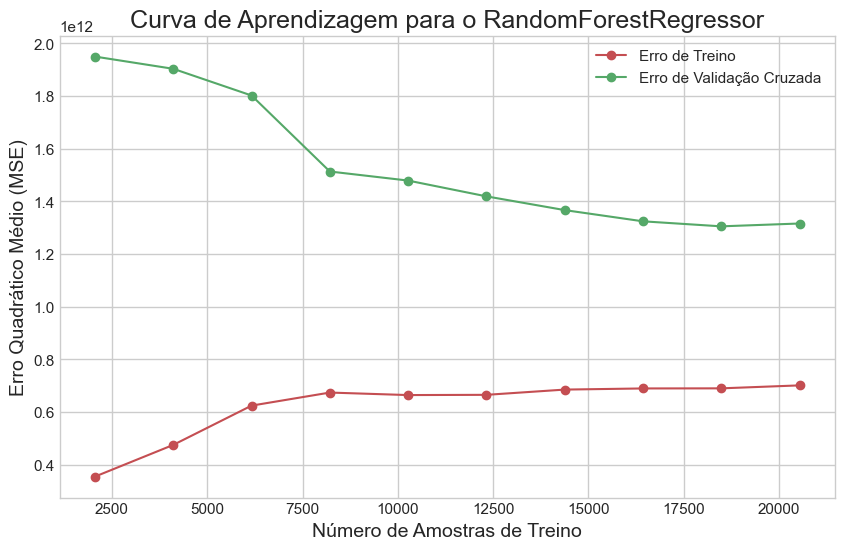

In [17]:
plot_learning_curve(best_model_RFR, "Curva de Aprendizagem para o RandomForestRegressor", X_train_processed, y_train_price)

In [18]:
param_dist = {
    'device': ['gpu'],
    'n_estimators': randint(200, 1500),
    'learning_rate': uniform(0.01, 0.1),
    'num_leaves': randint(5, 40),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4), # Amostra de 60% a 100% dos dados
    'colsample_bytree': uniform(0.6, 0.4) # Amostra de 60% a 100% das features
}

lgbm_model = LGBMRegressor(random_state=42, n_jobs=-1)

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_dist,
    n_iter=110,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search_lgbm.fit(X_train_processed, y_train_price)

print(f"Melhores parâmetros encontrados: {random_search_lgbm.best_params_}")
print(f"Melhor score (Negative MSE) na validação cruzada: {random_search_lgbm.best_score_:.4f}")

best_model_LGBM = random_search_lgbm.best_estimator_

predictions = best_model_LGBM.predict(X_test_processed)
r2 = r2_score(y_test_price, predictions)
mae = mean_absolute_error(y_test_price, predictions)
mape = mean_absolute_percentage_error(y_test_price, predictions)
mse = mean_squared_error(y_test_price, predictions)
rmse = np.sqrt(mse)

print("--- Métricas de Performance do Modelo LGBMRegressor ---")
print(f"R² (Coeficiente de Determinação): {r2:.4%}")
print(f"MAE (Erro Absoluto Médio): R$ {mae:,.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): R$ {rmse:,.2f}")
print(f"MAPE (Erro Percentual Absoluto Médio): {mape:.2%}%")

Fitting 5 folds for each of 110 candidates, totalling 550 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 25678, number of used features: 11
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (0.20 MB) transferred to GPU in 0.002608 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 930474.438157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

c:\Users\kevin\OneDrive\Documentos\FIAP\FIAP_aulas\Fase_3\FIAP-Tech-Challenge-Machine-Learning-Property\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


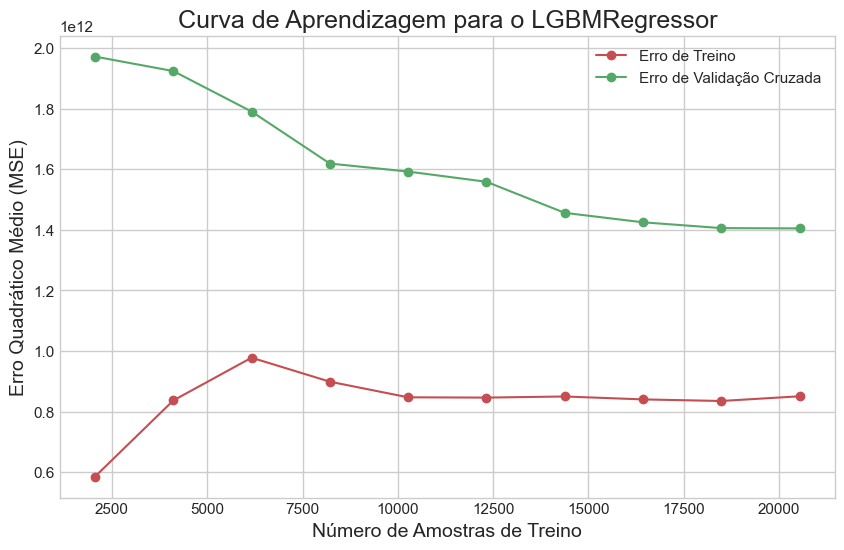

In [19]:
plot_learning_curve(best_model_LGBM, "Curva de Aprendizagem para o LGBMRegressor", X_train_processed, y_train_price)

In [20]:
param_dist = {
    'device': ['cuda'], # Faz com que o modelo utilize a GPU Nvidia
    'booster': ['gbtree'], # Define o tipo de modelo a cada interação
    'n_estimators': randint(200, 1300), # O número total de árvores a serem construidas
    'learning_rate': uniform(0.01, 0.2), # Define a complexidade do modelo, valores menores aumenta a robuste a overfitting
    'gamma': uniform(0.01, 0.7), # A redução mínima de perda (loss) necessária para realizar uma partição em um nó da árvore, quanto maior o valor mais conservador o modelo fica
    'lambda': uniform(0.1, 2), # Termo de regularização L2 (Ridge), valores maiores tornam o modelo mais conservador e suave
    'max_depth': randint(2, 10), # Define a profundidade máxima da arvore, valores maiores pode deixar o modelo sucetivel a overfitting
    'subsample': uniform(0.6, 0.4), # Amostra de 60% a 100% dos dados
    'colsample_bytree': uniform(0.6, 0.4), # Amostra de 60% a 100% das features
    'objective': ['reg:squarederror'] # Definindo a função de perda a ser minimizada
}

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)


random_search_xgb.fit(X_train_processed, y_train_price)

print(f"Melhores parâmetros encontrados: {random_search_xgb.best_params_}")
print(f"Melhor score (Negative MSE) na validação cruzada: {random_search_xgb.best_score_:.4f}")

best_model_XGB = random_search_xgb.best_estimator_

predictions = best_model_XGB.predict(X_test_processed)

predictions = best_model_XGB.predict(X_test_processed)
r2 = r2_score(y_test_price, predictions)
mae = mean_absolute_error(y_test_price, predictions)
mape = mean_absolute_percentage_error(y_test_price, predictions)
mse = mean_squared_error(y_test_price, predictions)
rmse = np.sqrt(mse)

print("--- Métricas de Performance do Modelo XGBRegressor ---")
print(f"R² (Coeficiente de Determinação): {r2:.4%}")
print(f"MAE (Erro Absoluto Médio): R$ {mae:,.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): R$ {rmse:,.2f}")
print(f"MAPE (Erro Percentual Absoluto Médio): {mape:.2%}%")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Melhores parâmetros encontrados: {'booster': 'gbtree', 'colsample_bytree': np.float64(0.7996773519539009), 'device': 'cuda', 'gamma': np.float64(0.41040293944642814), 'lambda': np.float64(1.637108028612618), 'learning_rate': np.float64(0.01872075435088675), 'max_depth': 5, 'n_estimators': 357, 'objective': 'reg:squarederror', 'subsample': np.float64(0.9815714308010349)}
Melhor score (Negative MSE) na validação cruzada: -1381172488256.4331
--- Métricas de Performance do Modelo XGBRegressor ---
R² (Coeficiente de Determinação): 65.6739%
MAE (Erro Absoluto Médio): R$ 370,576.73
RMSE (Raiz do Erro Quadrático Médio): R$ 1,075,061.34
MAPE (Erro Percentual Absoluto Médio): 42.46%%


c:\Users\kevin\OneDrive\Documentos\FIAP\FIAP_aulas\Fase_3\FIAP-Tech-Challenge-Machine-Learning-Property\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [21:41:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


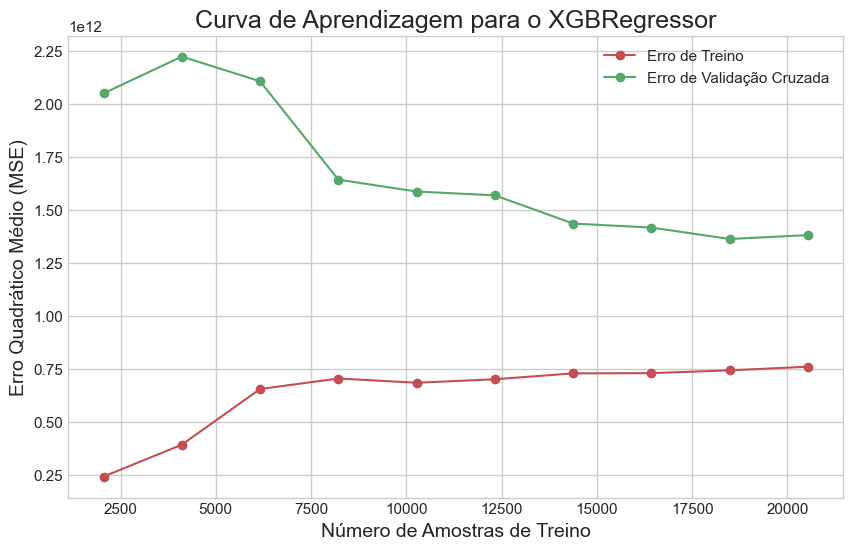

In [21]:
plot_learning_curve(best_model_XGB, "Curva de Aprendizagem para o XGBRegressor", X_train_processed, y_train_price)